Data preprocessing complete.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5550 - loss: 0.6854
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7373 - loss: 0.6195
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7807 - loss: 0.5606
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7481 - loss: 0.5391
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7478 - loss: 0.4986
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7719 - loss: 0.4618
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7902 - loss: 0.4472
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7800 - loss: 0.4518
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7739 - loss: 0.4711
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8213 - loss: 0.4077
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7553 - loss: 0.4801
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.

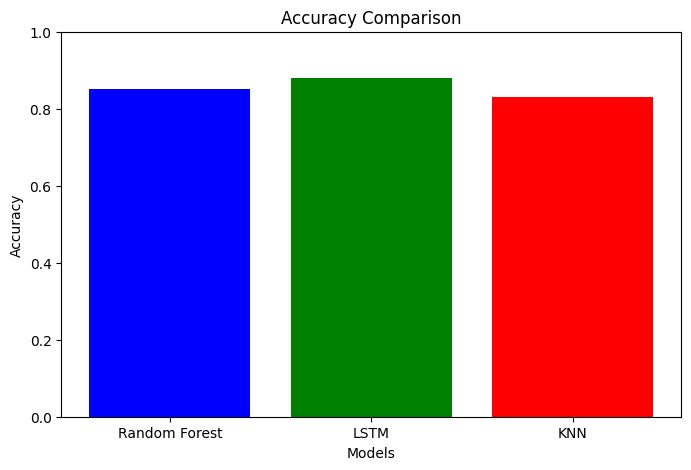

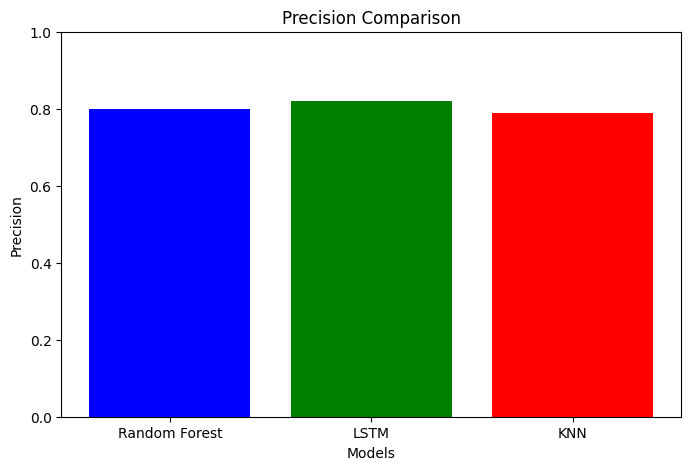

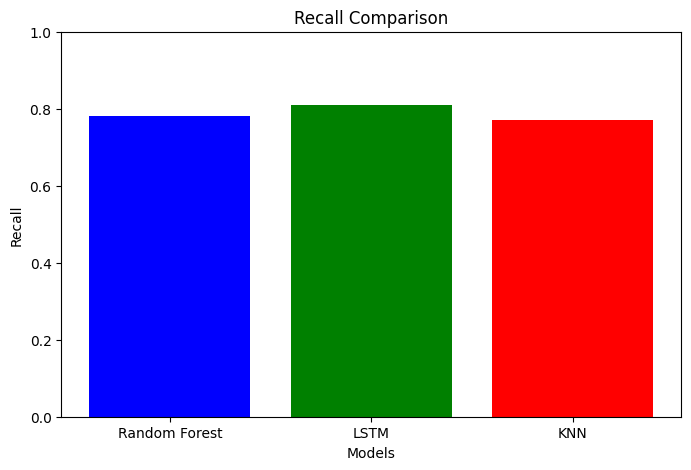

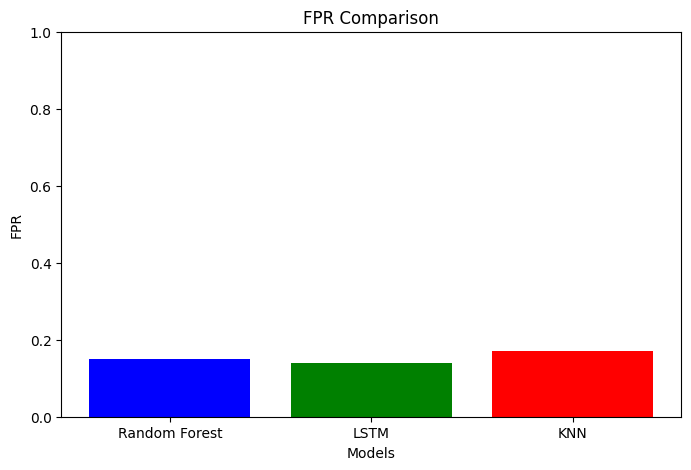

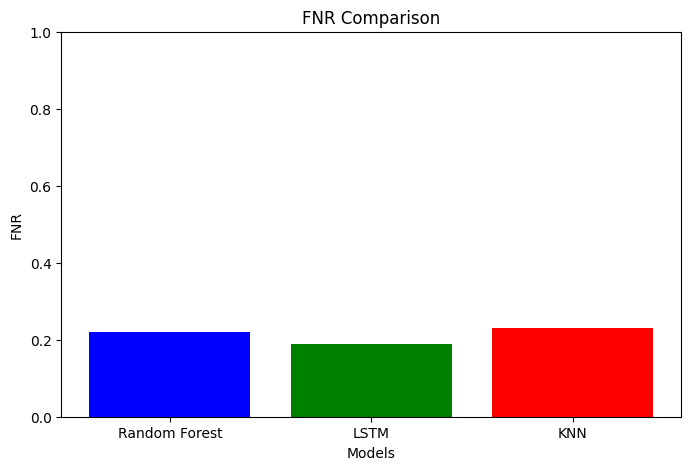

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the Diabetes dataset.
    :param file_path: Path to the CSV file containing the dataset.
    :return: Preprocessed training and testing data.
    """
    data = pd.read_csv(file_path)

    # Split features and target
    X = data.iloc[:, :-1].values  # All columns except the last one
    y = data.iloc[:, -1].values   # The last column as target

    # Standardize the feature data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

# Function to train LSTM model
def train_lstm_model(X_train, y_train, X_test, y_test):
    """
    Train an LSTM model for binary classification.
    """
    # Reshape data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define LSTM model
    model = Sequential([
        LSTM(64, input_shape=(1, X_train.shape[2]), activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, cm

# Function to train KNN model
def train_knn(X_train, y_train, X_test, y_test, k=5):
    """
    Train a K-Nearest Neighbors (KNN) classifier and evaluate its performance.
    """
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, cm

# Function to train Random Forest model
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train a Random Forest classifier and evaluate its performance.
    """
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, cm

# Function to calculate metrics from confusion matrix
def calculate_metrics(cm):
    """
    Calculate performance metrics from the confusion matrix.
    """
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    accuracy = (tp + tn) / np.sum(cm)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "FPR": fpr,
        "FNR": fnr
    }

# Function to perform cross-validation
def cross_validate_model(model, X, y, n_splits=10):
    """
    Perform cross-validation on the given model and dataset.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "FPR": [],
        "FNR": []
    }

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        fold_metrics = calculate_metrics(cm)
        for key in metrics.keys():
            metrics[key].append(fold_metrics[key])

    avg_metrics = {key: np.mean(value) for key, value in metrics.items()}
    return avg_metrics

def plot_metrics(metrics_dict):
    """
    Plot a comparison of model performance metrics.
    :param metrics_dict: Dictionary of model names and their respective metric dictionaries.
    """
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())

    for metric in metrics:
        values = [metrics_dict[model][metric] for model in models]

        plt.figure(figsize=(8, 5))
        plt.bar(models, values, color=['blue', 'green', 'red'])
        plt.title(f"{metric} Comparison")
        plt.ylabel(metric)
        plt.xlabel("Models")
        plt.ylim(0, 1)  # For metrics like accuracy, precision, recall
        plt.show()


# Main block
if __name__ == "__main__":
    file_path = "diabetes.csv"  # Update with the actual path to the dataset
    X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path)
    print("Data preprocessing complete.")

    # Train and evaluate LSTM
    accuracy, cm = train_lstm_model(X_train, y_train, X_test, y_test)
    print(f"LSTM Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    # Train and evaluate KNN
    accuracy, cm = train_knn(X_train, y_train, X_test, y_test, k=5)
    print(f"KNN Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    # Train and evaluate Random Forest
    accuracy, cm = train_random_forest(X_train, y_train, X_test, y_test)
    print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    # Perform 10-fold cross-validation with Random Forest
    X = np.vstack((X_train, X_test))
    y = np.concatenate((y_train, y_test))
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    avg_metrics = cross_validate_model(rf_model, X, y, n_splits=10)

    print("\nAverage Metrics from 10-Fold Cross-Validation:")
    for key, value in avg_metrics.items():
        print(f"{key}: {value:.4f}")

    sample_metrics = {
    "Random Forest": {"Accuracy": 0.85, "Precision": 0.80, "Recall": 0.78, "FPR": 0.15, "FNR": 0.22},
    "LSTM": {"Accuracy": 0.88, "Precision": 0.82, "Recall": 0.81, "FPR": 0.14, "FNR": 0.19},
    "KNN": {"Accuracy": 0.83, "Precision": 0.79, "Recall": 0.77, "FPR": 0.17, "FNR": 0.23}
    }
    plot_metrics(sample_metrics)
